<a href="https://colab.research.google.com/github/Nagalakshmi136/image-classification/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from datetime import datetime
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters

In [ ]:
learning_rate = 0.01
epochs = 200
batch_size = 128

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data Preparation

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_dataset = CIFAR10("./data", train = True, transform=transform_train, download=True)
test_dataset = CIFAR10("./data", train = False, transform=transform_test, download=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validate_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
len(train_loader.dataset)

50000

In [ ]:
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(train_loader)
train_images, train_labels = next(dataiter)
# call function on our images
imshow(make_grid(train_images))

# print the class of the image
print(' '.join('%s' % classes[train_labels[j]] for j in range(batch_size)))

## ResNet 18 Implementation

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down_sample):
        super(ResNetBlock,self).__init__()
        self.skip_connection = nn.Sequential()
        if down_sample:
            self.conv1 = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(3,3),
                stride=(2,2),
                padding=(1,1)
            )

            self.skip_connection = nn.Sequential(
                nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(1,1),
                stride=(2,2),
                padding=(0,0)
                ),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(3,3),
                stride=(1,1),
                padding=(1,1)
            )
        self.bnorm1=nn.BatchNorm2d(out_channels)
        self.bnorm2=nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=(3,3),
                stride=(1,1),
                padding=(1,1)
            )
    def forward(self, input):
        skip_conn = self.skip_connection(input)
        input = nn.ReLU()(self.bnorm1(self.conv1(input)))
        input = nn.ReLU()(self.bnorm2(self.conv2(input)))
        input = nn.ReLU()(input+skip_conn)
        return input



In [ ]:
def conv_block(in_channels, out_channels):
  return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3,3),
            stride=(1,1),
            padding=(1,1)
            ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
  )

class ResNet(nn.Module):
    def __init__(self,num_classes) -> None:
        super().__init__()
        self.conv1 = conv_block(3,64)
        self.layer1 = nn.Sequential(
            ResNetBlock(64,64,True),
            ResNetBlock(64,64,False)
            )
        self.layer2 = nn.Sequential(
            ResNetBlock(64,128,True),
            ResNetBlock(128,128,False)
            )
        self.layer3 = nn.Sequential(
            ResNetBlock(128,256,True),
            ResNetBlock(256,256,False)
            )
        self.layer4 = nn.Sequential(
            ResNetBlock(256,512,True),
            ResNetBlock(512,512,False)
        )
        self.linear = nn.Linear(in_features=512,out_features=num_classes)

    def forward(self, input_data):
        output = self.conv1(input_data)
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = F.avg_pool2d(output,output.size()[3])
        output = output.view(output.shape[0],-1)
        output = self.linear(F.dropout(output))
        probs = F.softmax(output,dim=1)
        return probs



## Training the Model

In [ ]:
def train(train_loader, model, optimizer, criterion):
    running_loss = 0.0
    for train_images, train_labels in tqdm(train_loader):
        # images, labels = batch_data
        train_images = train_images.to(device)
        train_labels = train_labels.to(device)
        optimizer.zero_grad()
        output_labels = model(train_images) # forward
        loss = criterion(output_labels,train_labels) # loss
        running_loss += loss.item()*train_images.size(0)
        loss.backward() # backward
        optimizer.step() # update weights
    epoch_loss=running_loss/len(train_loader.dataset)
    return model,optimizer,epoch_loss

In [ ]:
def validate(validate_loader,model,criterion):
    running_loss = 0.0
    with torch.no_grad():
        for validate_images, validate_labels in tqdm(validate_loader):
            validate_images = validate_images.to(device)
            validate_labels = validate_labels.to(device)
            output_labels = model(validate_images)
            loss = criterion(output_labels,validate_labels)
            running_loss += loss.item()*validate_images.size(0)
    epoch_loss=running_loss/len(validate_loader.dataset)
    return model,epoch_loss


In [ ]:
def get_accuracy(model,data_loader):
    correct_pred=0
    total_size = len(data_loader.dataset)
    with torch.no_grad():
        for input_images,input_labels in data_loader:

            input_images= input_images.to(device)
            input_labels = input_labels.to(device)

            predicted_labels = model(input_images)
            predicted_labels = torch.argmax(predicted_labels,dim=1).flatten()
            correct_pred += torch.eq(predicted_labels,input_labels).sum().item()
    return float(correct_pred/total_size)*100

# Plotting Graphs

In [ ]:
def plot_losses(train_losses, validate_losses,epochs):
    train_losses=np.array(train_losses)
    validate_losses=np.array(validate_losses)
    _, ax = plt.subplots(figsize = (epochs,5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(validate_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()

def plot_accuracy(train_accuracy, validate_accuracy,epochs):
    train_accuracy=np.array(train_accuracy)
    validate_accuracy=np.array(validate_accuracy)
    _, ax = plt.subplots(figsize = (epochs,5))

    ax.plot(train_accuracy, color='blue', label='Training loss')
    ax.plot(validate_accuracy, color='red', label='Validation loss')
    ax.set(title="Accuracy over epochs",
            xlabel='Epoch',
            ylabel='Accuracy')
    ax.legend()

In [ ]:
def training_loop(train_loader,validate_loader,model,criterion,optimizer,epochs,print_loss=False ):
    train_losses = []
    validate_losses = []
    train_accuracy = []
    validate_accuracy = []
    k=0
    for epoch in range(epochs):
        model,optimizer,train_loss=train(train_loader=train_loader,model=model,optimizer=optimizer,criterion=criterion)
        train_losses.append(train_loss)
        with torch.no_grad():
            model,validate_loss=validate(validate_loader=validate_loader,model=model,criterion=criterion)
            validate_losses.append(validate_loss)
        if print_loss and k==0 or epoch%k==0 or epoch==epochs-1:
            train_acc=get_accuracy(model,train_loader)
            valid_acc=get_accuracy(model=model,data_loader=validate_loader)
            train_accuracy.append(train_acc)
            validate_accuracy.append(valid_acc)
            print(f"{datetime.now().time().replace(microsecond=0)}----"
                  f"Epoch: {epoch}\t"
                  f"Train loss: {train_loss:.4f}\t"
                  f"Valid loss: {validate_loss:.4f}\t"
                  f"Train accuracy: {train_acc:.2f}\t"
                  f"Valid accuracy: {valid_acc:.2f}")
            k+=epochs//10
    plot_losses(train_losses=train_losses,validate_losses=validate_losses,epochs=epochs)
    plot_accuracy(train_accuracy=train_accuracy,validate_accuracy=validate_accuracy,epochs=epochs)
    return model,optimizer,(train_accuracy[-1],validate_accuracy[-1])


In [ ]:
model = ResNet(10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9,weight_decay=5e-4)

100%|██████████| 79/79 [00:02<00:00, 29.02it/s]


12:36:54----Epoch: 0	Train loss: 2.0869	Valid loss: 1.9816	Train accuracy: 45.57	Valid accuracy: 47.55


100%|██████████| 79/79 [00:02<00:00, 29.31it/s]


12:48:39----Epoch: 20	Train loss: 1.6646	Valid loss: 1.6605	Train accuracy: 80.22	Valid accuracy: 79.95


100%|██████████| 79/79 [00:02<00:00, 26.67it/s]


13:00:32----Epoch: 40	Train loss: 1.6054	Valid loss: 1.6215	Train accuracy: 86.19	Valid accuracy: 83.99


100%|██████████| 79/79 [00:02<00:00, 28.38it/s]


13:12:33----Epoch: 60	Train loss: 1.5776	Valid loss: 1.6033	Train accuracy: 88.87	Valid accuracy: 85.83


100%|██████████| 79/79 [00:02<00:00, 28.02it/s]


13:24:57----Epoch: 80	Train loss: 1.5668	Valid loss: 1.5999	Train accuracy: 89.29	Valid accuracy: 86.30


100%|██████████| 79/79 [00:02<00:00, 28.64it/s]


13:36:59----Epoch: 100	Train loss: 1.5701	Valid loss: 1.5975	Train accuracy: 89.37	Valid accuracy: 86.39


100%|██████████| 79/79 [00:02<00:00, 29.14it/s]


13:49:22----Epoch: 120	Train loss: 1.5659	Valid loss: 1.5958	Train accuracy: 89.68	Valid accuracy: 86.73


100%|██████████| 79/79 [00:02<00:00, 27.55it/s]


14:01:28----Epoch: 140	Train loss: 1.5606	Valid loss: 1.5926	Train accuracy: 89.85	Valid accuracy: 87.01


100%|██████████| 79/79 [00:02<00:00, 27.91it/s]


14:13:27----Epoch: 160	Train loss: 1.5599	Valid loss: 1.5826	Train accuracy: 90.94	Valid accuracy: 88.08


100%|██████████| 79/79 [00:03<00:00, 25.50it/s]


14:25:35----Epoch: 180	Train loss: 1.5571	Valid loss: 1.5828	Train accuracy: 91.32	Valid accuracy: 87.96


100%|██████████| 79/79 [00:02<00:00, 27.68it/s]


14:37:28----Epoch: 199	Train loss: 1.5556	Valid loss: 1.5826	Train accuracy: 91.21	Valid accuracy: 87.95


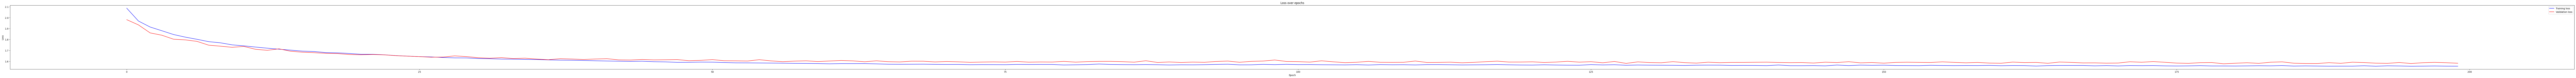

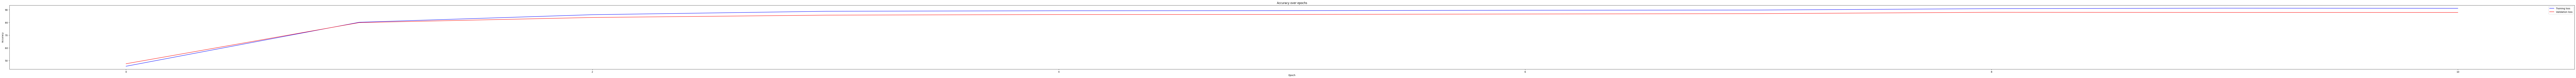

In [ ]:
model, optimizer, accuracies = training_loop(train_loader=train_loader, validate_loader=validate_loader,model=model,optimizer=optimizer,criterion=criterion,epochs=epochs,print_loss=True)